In [99]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

## Data preprocessing

In [76]:
data = pd.read_csv('spam.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [77]:
data.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [78]:
# on va rendre les données equivalante utilisant la méthode de downsample
data_spam = data[data['Category']  == 'spam']
data_ham = data[data['Category']  == 'ham'].sample(747)

In [79]:
print(data_spam.shape)
print(data_ham.shape)

(747, 2)
(747, 2)


In [80]:
balanced_data = pd.concat([data_spam, data_ham])
balanced_data

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
1139,ham,What * u wearing?
1188,ham,There's no point hangin on to mr not right if ...
5238,ham,Yeah I can still give you a ride
172,ham,"Hmmm.. Thk sure got time to hop ard... Ya, can..."


In [81]:
balanced_data['spam'] = balanced_data['Category'].apply(lambda x: 1 if x=='spam'else 0)
balanced_data.sample(5)

,Category,Message,spam
2124,spam,#ERROR!,1
725,ham,The world is running and i am still.maybe all ...,0
4879,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,1
4473,spam,3. You have received your mobile content. Enjoy,1
3180,ham,Does cinema plus drink appeal tomo? * Is a fr ...,0


In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_data['Message'], balanced_data['spam'], stratify= balanced_data['spam'])


In [83]:
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/multi-cased-preprocess/3")
encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/multi-cased-l-12-h-768-a-12/4")

In [84]:
def embedding_sentences(sentence):
    preprocessed_text = preprocessor(sentence)
    return encoder(preprocessed_text)['pooled_output']

## Build Tensorflow Model : Functional model

In [85]:
# bert layers
input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name= "Text")
preprocessed_text = preprocessor(input_text)
outputs = encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
s = tf.keras.layers.Dense(1, activation= 'sigmoid', name = "output")(l)

# Final Model
model = tf.keras.Model(inputs=[input_text], outputs=[s])


In [89]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_8 (KerasLayer)     {'input_type_ids':   0           ['Text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [87]:
Metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='Recall')
]
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics= Metrics
)

In [90]:
model.fit(X_train,y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 558s 16s/step - loss: 0.5785 - accuracy: 0.8179 - Precision: 0.7908 - Recall: 0.8643
Epoch 2/5
35/35 [==============================] - 1929s 56s/step - loss: 0.5035 - accuracy: 0.8821 - Precision: 0.8579 - Recall: 0.9161
Epoch 3/5
35/35 [==============================] - 565s 16s/step - loss: 0.4408 - accuracy: 0.9161 - Precision: 0.9059 - Recall: 0.9286
Epoch 4/5
35/35 [==============================] - 568s 16s/step - loss: 0.4015 - accuracy: 0.9045 - Precision: 0.8925 - Recall: 0.9196
Epoch 5/5
35/35 [==============================] - 604s 17s/step - loss: 0.3639 - accuracy: 0.9259 - Precision: 0.9177 - Recall: 0.9357


In [91]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 192s 16s/step - loss: 0.3582 - accuracy: 0.9251 - Precision: 0.8955 - Recall: 0.9626


[0.35819151997566223, 0.9251337051391602, 0.89552241563797, 0.9625668525695801]

In [94]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

12/12 [==============================] - 188s 16s/step


In [95]:
y_pred = np.where(y_pred>0.5, 1, 0)

In [96]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
cm

array([[166,  21],
       [  7, 180]], dtype=int64)

Text(33.0, 0.5, 'real value')

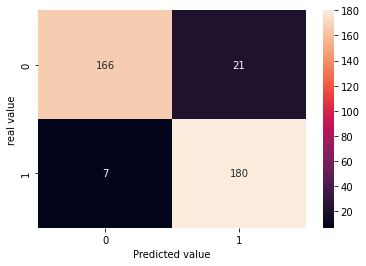

In [102]:
sn.heatmap(cm, annot=True , fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('real value')

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       187
           1       0.90      0.96      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [105]:
test_eamils = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(test_eamils)

1/1 [==============================] - 6s 6s/step


array([[0.78130037],
       [0.84475183],
       [0.7883719 ],
       [0.48681465],
       [0.24044217]], dtype=float32)